# Using CTGAN to synthesise data

Source: https://github.com/sdv-dev/CTGAN

- Uses Python to generate synthetic data
- Uses R for evaluation 

In [2]:
from ctgan import CTGANSynthesizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load dataset

In [49]:
df = pd.read_csv("./original_data/satgpa.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sex      1000 non-null   int64  
 1   sat_v    1000 non-null   int64  
 2   sat_m    1000 non-null   int64  
 3   sat_sum  1000 non-null   int64  
 4   hs_gpa   1000 non-null   float64
 5   fy_gpa   1000 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 47.0 KB


In [50]:
df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,65,62,127,3.40,3.18
1,2,58,64,122,4.00,3.33
2,2,56,60,116,3.75,3.25
3,1,42,53,95,3.75,2.42
4,1,55,52,107,4.00,2.63


In [51]:
# Set discrete columns
discrete_cols = [
    'sex'
]

## Generate synthetic data

In [66]:
help(CTGANSynthesizer)

Help on class CTGANSynthesizer in module ctgan.synthesizers.ctgan:

class CTGANSynthesizer(ctgan.synthesizers.base.BaseSynthesizer)
 |  CTGANSynthesizer(embedding_dim=128, generator_dim=(256, 256), discriminator_dim=(256, 256), generator_lr=0.0002, generator_decay=1e-06, discriminator_lr=0.0002, discriminator_decay=1e-06, batch_size=500, discriminator_steps=1, log_frequency=True, verbose=False, epochs=300, pac=10, cuda=True)
 |  
 |  Conditional Table GAN Synthesizer.
 |  
 |  This is the core class of the CTGAN project, where the different components
 |  are orchestrated together.
 |  For more details about the process, please check the [Modeling Tabular data using
 |  Conditional GAN](https://arxiv.org/abs/1907.00503) paper.
 |  Args:
 |      embedding_dim (int):
 |          Size of the random sample passed to the Generator. Defaults to 128.
 |      generator_dim (tuple or list of ints):
 |          Size of the output samples for each one of the Residuals. A Residual Layer
 |        

In [68]:
model = CTGANSynthesizer()
model.fit(df, discrete_cols)

C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 

In [69]:
synth_df = model.sample(1000)

In [70]:
synth_df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,33,72,117,3.305693,3.933615
1,1,64,65,121,3.479289,3.661572
2,1,51,75,102,3.139655,3.808304
3,1,64,80,119,2.837041,3.717887
4,1,80,64,145,3.476595,2.666414


In [56]:
# Output
synth_output = "./synth_data/ctgan_method.csv"

In [57]:
synth_df.to_csv(synth_output, sep=",")

## Evaluation

In [6]:
# Read in synth data
synth_df = pd.read_csv(synth_output)

Use R: synthpop package

In [22]:
# Enables R in the notebook, only need to run once
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [71]:
%%R -i df,synth_df
# Imports both dataframes from global environment

# Does high school GPA predict first year uni GPA?
real_coeff <- lm(hs_gpa ~ fy_gpa, data = df)
synth_coeff <- lm(hs_gpa ~ fy_gpa, data = synth_df)

print(real_coeff)
print(synth_coeff)

# Confidence interval overlap
ci_real_low <- confint(real_coeff, 'fy_gpa', level=0.95)[1]
ci_real_high <- confint(real_coeff, 'fy_gpa', level=0.95)[2]
ci_synth_low <- confint(synth_coeff, 'fy_gpa', level=0.95)[1]
ci_synth_high <- confint(synth_coeff, 'fy_gpa', level=0.95)[2]

cat(ci_real_low, ci_real_high, ci_synth_low, ci_synth_high)

io <- 0.5 * (
    (min(ci_real_high, ci_synth_high) - max(ci_real_low, ci_synth_low))/(ci_real_high - ci_real_low) +
    (min(ci_real_high, ci_synth_high) - max(ci_real_low, ci_synth_low))/(ci_synth_high - ci_synth_low)
)

print(io)


Call:
lm(formula = hs_gpa ~ fy_gpa, data = df)

Coefficients:
(Intercept)       fy_gpa  
     2.2176       0.3973  


Call:
lm(formula = hs_gpa ~ fy_gpa, data = synth_df)

Coefficients:
(Intercept)       fy_gpa  
     2.2605       0.1869  

0.3591505 0.4354067 0.1390901 0.2347514[1] -1.465871


[1] -0.01712538


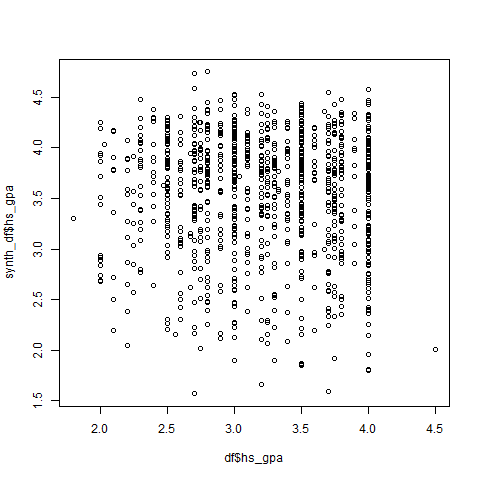

In [64]:
%%R -i df,synth_df
# Imports both dataframes from global environment

print(cor(df$hs_gpa, synth_df$hs_gpa))
plot(df$hs_gpa, synth_df$hs_gpa, type = "p")